In [8]:
import os
import sys 
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 

from qmvpa import utils, factor, rsa
from data_loader_local import load_data
from dep.utils import subset_units
from config import get_log_info

from matplotlib.ticker import FormatStrFormatter

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


In [9]:
# get roots 
log_root = '/tigress/qlu/logs/keras-resnet/log'
plt_root = '/tigress/qlu/logs/keras-resnet/plots'
pltdata_root = '/tigress/qlu/logs/keras-resnet/plots_data'

# define data name, model name 
data_name = 'cifar100'
model_name = 'resnet18'

# load data 
_, _, _, _, _, labels, data_info = load_data(data_name)
[n_classes, img_rows, img_cols, img_channels] = data_info
n_test_egs = len(labels)

# define params 
log_info_list = get_log_info(data_name, model_name)
n_subjs, layer_selected, n_layers, log_epochs, n_log_epochs = log_info_list
if model_name == 'conv': 
    layer_selected = layer_selected[:3]
    n_layers -=1 
    
print('log epochs', log_epochs)
print('layer selected', layer_selected)

log epochs [  0   1   2   3   5   8  13  22  36  60 100]
layer selected [2, 10, 17, 25, 32, 40, 47, 55, 62]


In [10]:
# init the big df 
column_names = ['var_exp', 'layer_id', 'epoch', 'netid']
df_var_exp = pd.DataFrame(columns = column_names)

# for each layer, look at the development 
# i_l, i_e = -2, -2
# for (i_l, i_e) in product(range(2), range(2)):
for (i_l, i_e) in product(range(n_layers), range(n_log_epochs)):
    l, e = layer_selected[i_l], log_epochs[i_e]
    # plot dir and plot data dir 
    plt_dir = os.path.join(
        plt_root, data_name, model_name, 
        'epoch_%.3d' % e, 'rsa')    
    pltdata_dir = os.path.join(
        pltdata_root, data_name, model_name, 
        'epoch_%.3d' % e, 'rsa')
    # RSA and SRM result path
    srm_result_fname = 'srm_l%.2d.npy' % (l)
    srm_result_path = os.path.join(pltdata_dir, srm_result_fname)
    [Xs_test, Xs_test_s, y_test, 
     Ws, S, srmn_features, 
     var_exp_train, var_exp_test
    ] = np.load(srm_result_path)
    # calc var exp
    Ss = [np.mean(Xs_test_s, axis = 0) for _ in range(n_subjs)]
    var_exp_le = factor.calc_srm_var_exp(Xs_test, Ss, Ws)
    # concate new df to the big df
    data_temp = [
        var_exp_le, 
        np.repeat(l, n_subjs), 
        np.repeat(e, n_subjs), 
        np.arange(n_subjs)
    ]
    df_temp = pd.DataFrame({
        column_names[i]: data_temp[i] for i in range(len(column_names))
    })
    df_var_exp = pd.concat([df_var_exp, df_temp])
    print('Collected: layer = %d, epoch = %d' % (l, e))

Collected: layer = 2, epoch = 0
Collected: layer = 2, epoch = 1
Collected: layer = 2, epoch = 2
Collected: layer = 2, epoch = 3
Collected: layer = 2, epoch = 5
Collected: layer = 2, epoch = 8
Collected: layer = 2, epoch = 13
Collected: layer = 2, epoch = 22
Collected: layer = 2, epoch = 36
Collected: layer = 2, epoch = 60
Collected: layer = 2, epoch = 100
Collected: layer = 10, epoch = 0
Collected: layer = 10, epoch = 1
Collected: layer = 10, epoch = 2
Collected: layer = 10, epoch = 3
Collected: layer = 10, epoch = 5
Collected: layer = 10, epoch = 8
Collected: layer = 10, epoch = 13
Collected: layer = 10, epoch = 22
Collected: layer = 10, epoch = 36
Collected: layer = 10, epoch = 60
Collected: layer = 10, epoch = 100
Collected: layer = 17, epoch = 0
Collected: layer = 17, epoch = 1
Collected: layer = 17, epoch = 2
Collected: layer = 17, epoch = 3
Collected: layer = 17, epoch = 5
Collected: layer = 17, epoch = 8
Collected: layer = 17, epoch = 13
Collected: layer = 17, epoch = 22
Collect

mean_var_exp_last_layer:  0.8480760715216973


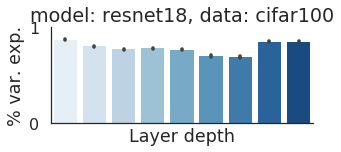

In [11]:
"""plot the variance explained curve for the last layer
"""
var_sep = 'epoch'
layer_plt = np.unique(df_var_exp[var_sep])
epoch_plt = np.unique(df_var_exp['epoch'])
last_epoch = epoch_plt[-1]

n_layer_plt = len(layer_plt)
cur_pal = sns.color_palette("Greens", n_colors=4)
b_pals = sns.color_palette("Blues", n_colors = n_layers)

df_var_exp_l_ = df_var_exp[df_var_exp['epoch'] == last_epoch]

f, ax = plt.subplots(1,1, figsize = (5, 2.5))
sns.barplot(
    x = 'layer_id', y = 'var_exp', 
    ci = 95, 
    palette=b_pals, 
    color = cur_pal[-1], 
    data = df_var_exp_l_, 
    ax = ax
)

ax.set_title("model: %s, data: %s" % (model_name, data_name))
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1])
ax.set_ylabel('% var. exp.')
ax.set_xlabel('Layer depth')
ax.set_xticks([])
sns.despine()
f.tight_layout()


# print var_exp for the last layer 
mean_var_exp_last_layer = np.mean(
    df_var_exp_l_[df_var_exp_l_['layer_id'] == np.max(df_var_exp_l_['layer_id'])]['var_exp']
)
print('mean_var_exp_last_layer: ', mean_var_exp_last_layer)

# save plot 
temp_path = '/tigress/qlu/logs/temp/'
fname = 'varexp_b_%s_%s.png' % (model_name, data_name)
f.savefig(os.path.join(temp_path, fname),  bbox_inches='tight', dpi = 200)